In [1]:
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.optimize
%matplotlib inline
from numpy import asarray

# Data from experiment 3 (groups A, B & C)

In [2]:
# t1 is for Cx and t2 is for rCO2 (both are in hours)
t1 = numpy.array([1.5, 2.5, 3.5, 4.5, 5.5])
t2 = numpy.array([1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25])

In [3]:
# A3
Cx_A = numpy.array([0.9048, 1.0947, 1.4945, 1.9289, 2.4327]) # g/L
rco2_A = numpy.array([3.12, 4.02, 4.94, 5, 6.24, 7.22, 8.2, 9.22, 9.8]) # ml/min

In [4]:
# B3
Cx_B = numpy.array([0.972, 0.975, 1.4, 1.48, 1.82]) # g/L
rco2_B = numpy.array([2.07, 2.89, 3.49, 4.21, 5.14, 6.98, 8.25, 9.09, 9.65]) # ml/min

In [5]:
# C3
Cx_C = numpy.array([0.904, 0.9636, 1.5332, 1.8841, 2.3654]) # g/L
rco2_C = numpy.array([1.8533, 2.7467, 3.2333, 5.1067, 5.8467, 6.4, 7.1933, 9.0533, 9.3333]) # ml/min

# Calculating average values of Cx and rCO2\

        - Cx of B wasnt considered as it results in a less accurate fit for μ

In [6]:
Cx_avg=[]  

for index,value in enumerate(Cx_A):
    sum_avg=Cx_A[index]+Cx_C[index]
    Cx_avg.append(sum_avg/2)

Cx_avg

[0.9044000000000001, 1.02915, 1.51385, 1.9065, 2.39905]

In [7]:
rco2_avg=[]

for index,value in enumerate(rco2_A):
    sum_avg=rco2_A[index]+rco2_C[index]+rco2_B[index]
    rco2_avg.append(sum_avg/3)

rco2_avg

[2.347766666666667,
 3.2189,
 3.8877666666666673,
 4.772233333333333,
 5.742233333333334,
 6.866666666666667,
 7.8811,
 9.1211,
 9.594433333333333]

# Determintation of Cx0 and initial μ

In [8]:
def bio(t,mu1,CA0):

    return CA0*scipy.e**(mu1*(t))

In [9]:
t3 = numpy.array([0,1.5, 2.5, 3.5, 4.5, 5.5])

 μ = 0.2548771059796611 Cx0 = 0.5962362812163048


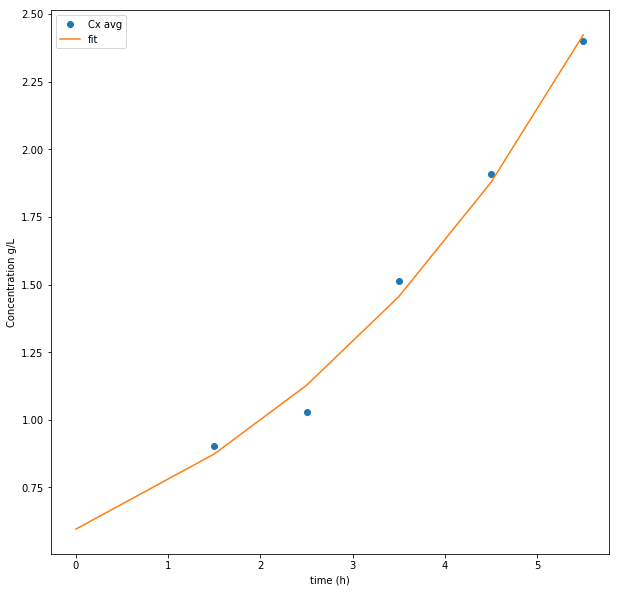

In [10]:
params = scipy.optimize.curve_fit(bio,t1,Cx_avg,p0 =(0.5,0.5))[0]
mu_fit,Ca0_fit = params

print (' μ =', mu_fit, 'Cx0 =', Ca0_fit)

Cx_fit= bio(t3,mu_fit,Ca0_fit)

plt.figure(figsize=(10,10))
plt.plot(t1,Cx_avg,"o", label = 'Cx avg')
plt.plot(t3,Cx_fit, label = 'fit')

plt.legend(loc='best')
plt.ylabel('Concentration g/L') 
plt.xlabel('time (h)') 
plt.show()

# Setting up of ferm equation and response function

In [11]:
alpha, beta, theta = 0.1, 0.1, 0.05

In [12]:
def response_fun(C):
    
    Cx, Ce, Cs = C
        
    S = numpy.matrix([[-1,1+alpha,1,0,0],
                      [ 0,0,-1,1,1.5],
                      [  0,beta,0,-1/3,0],
                      [ 0,-gamma,-1/3,0,1],
                      [ 0,1,0,0,0]])

    sol = numpy.matrix([0, 0, 0, theta, mu]).T
    r = numpy.linalg.solve(S, sol) 
        
    
    return [mu,        # biomass
            r[4,0],    # ethanol  
            -r[0, 0]]   # glucose

In [13]:
def ferm_eq(C,t):
    Cx, Ce, Cs = C 
    r=response_fun(C)
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]   

# Biomass production  rate
    - checking how well the initail μ value fits

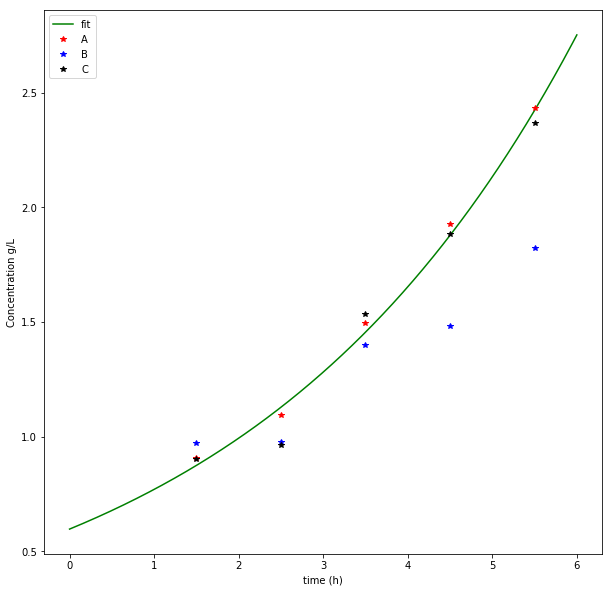

In [14]:
mu = mu_fit
gamma = 1.31
Cx0 = Ca0_fit

Co=[Cx0, 0, (35*2)]
tmax = 6
tspan=numpy.linspace(0,tmax,tmax*100+1)            
C = odeint(ferm_eq, Co, tspan)

Cx = C[:,0]      
Ce = C[:,1]
Cs = C[:, 2]

plt.figure(figsize=(10,10))
plt.plot(tspan, Cx, color='green',label='fit')
plt.plot(t1, Cx_A,'*', color='red', label='A')
plt.plot(t1, Cx_B,'*', color='blue', label='B')
plt.plot(t1, Cx_C, '*', color='black', label='C')

plt.legend(loc='best')
plt.ylabel('Concentration g/L') 
plt.xlabel('time (h)') 
plt.show()

# CO2 production rate

    - with guess value for γ  

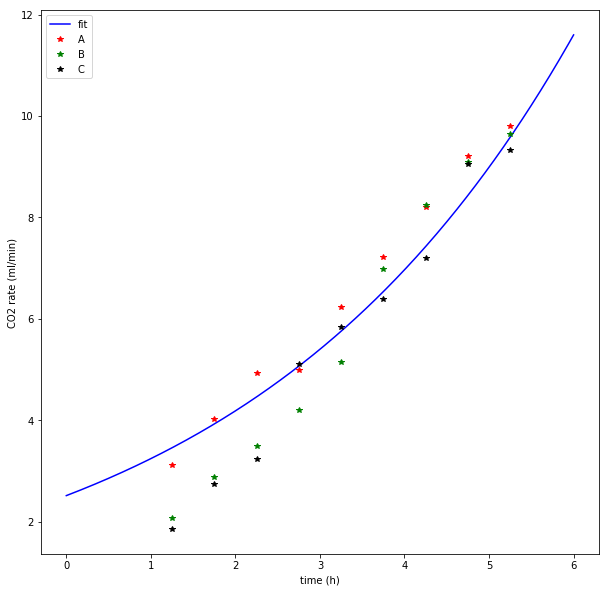

In [15]:
Ci=(C[:, :1])                                 
r=asarray([response_fun(C) for C in C])        

T, P = 23, 86  # °C, kPa 

rx=r[:,0]
re=r[:,1]
rco2=(0.5*re+alpha*rx)*(1/60)*8.314*(T+273)*1000/P*(Cx/24.6)*0.5  #ml CO2/min   

plt.figure(figsize=(10,10))
plt.plot(tspan, rco2, color='blue', label='fit')
plt.plot(t2, rco2_A, '*', color='red',label='A')
plt.plot(t2, rco2_B, '*', color='green',label='B')
plt.plot(t2, rco2_C, '*', color='black',label='C')

plt.legend(loc='best')
plt.ylabel('CO2 rate (ml/min)') 
plt.xlabel('time (h)') 
plt.show()

# Determination of more accurate γ 

### Jarryd's shit

In [16]:
def ferm_eq_2(t,C):
    Cx, Ce, Cs = C 
    r=response_fun_2(C)
    
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx]   

In [17]:
error=1000

for gamma in numpy.arange(0,2,0.01):
    squares=0
    
    def response_fun_2(C):
    
        Cx, Ce, Cs = C

        S = numpy.matrix([[-1,1+alpha,1,0,0],
                          [ 0,0,-1,1,1.5],
                          [  0,beta,0,-1/3,0],
                          [ 0,-gamma,-1/3,0,1],
                          [ 0,1,0,0,0]])

        sol = numpy.matrix([0, 0, 0, theta, mu]).T
        r = numpy.linalg.solve(S, sol) 


        return [mu,        # biomass
                r[4,0],    # ethanol  
                r[0, 0]]   # glucose
    
    Co=[Cx0, 0, (35*2)]
    tspan1=[0,6]   
#     print (Co)
    C = scipy.integrate.solve_ivp(ferm_eq_2, tspan1, Co, t_eval=t2).y
#     print (C)
    
    fitted_rco2_list=[]
    
    for index,value in enumerate(rco2_avg):
#         print ((C[0][index], C[1][index], C[2][index]))
        rates = response_fun_2((C[0][index], C[1][index], C[2][index]))
        rx, re, rs = rates
        cx=Cx[numpy.where(numpy.linspace(0,tmax,tmax*100+1) == t2[index])]
#         print (numpy.where(numpy.linspace(0,tmax,tmax*100+1) == t2[index]))
      
        fitted_rco2 = (0.5*re+alpha*rx)*(1/60)*8.314*(T+273)*1000/P*(cx)/24.6*0.5
#         print (fitted_rco2, value, gamma)
        squares+=(fitted_rco2-value)**2
#         print (squares)
        fitted_rco2_list.append(fitted_rco2)
    if squares<error:
#         print (squares, gamma)
        gamma_acc=gamma
        error=squares
        fitted_rco2_acc=fitted_rco2_list
#     print (squares, gamma)

In [18]:
gamma_acc

1.31

In [19]:
gamma=gamma_acc

[0.2548771059796611, 0.2548771059796611, 0.2548771059796611, 0.2548771059796611, 0.2548771059796611, 0.2548771059796611, 0.2548771059796611, 0.2548771059796611, 0.2548771059796611] [0.8187534388626443, 0.8187534388626443, 0.8187534388626443, 0.8187534388626443, 0.8187534388626443, 0.8187534388626443, 0.8187534388626443, 0.8187534388626443, 0.8187534388626443]


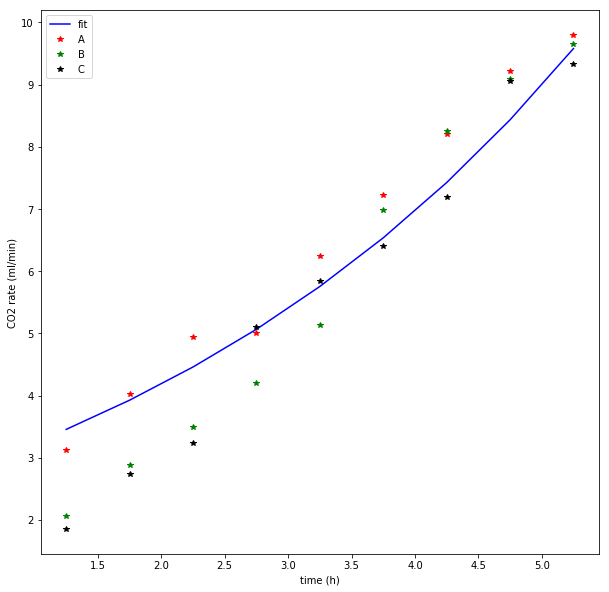

In [20]:
# Ci=(C[:, :1]) 
# print (Ci)
# r=asarray([response_fun(Ci) for C in C])       

r=[]
rx=[]
re=[]
for values in zip(C[0],C[1],C[2]):
    r.append(response_fun(values))
    rx.append(response_fun(values)[0])
    re.append(response_fun(values)[1])
    
print (rx, re)

T, P = 23, 86  # °C, kPa 
 
plt.figure(figsize=(10,10))
plt.plot(t2, fitted_rco2_acc, color='blue', label='fit')
plt.plot(t2, rco2_A, '*', color='red',label='A')
plt.plot(t2, rco2_B, '*', color='green',label='B')
plt.plot(t2, rco2_C, '*', color='black',label='C')

plt.legend(loc='best')
plt.ylabel('CO2 rate (ml/min)') 
plt.xlabel('time (h)') 
plt.show()

# Comparing all 12 data sets to experiment 3 results

In [21]:
# A1
Cx_A1 = numpy.array([0.8482, 0.9537, 1.3007, 1.6067, 2.0595]) # g/L
rco2_A1 = numpy.array([2.6, 3, 3.7, 4, 4.7, 5.2, 6.1, 7.1, 8.1])

In [22]:
# A2
Cx_A2 = numpy.array([0.8711, 0.9805, 1.3905, 1.5822, 1.9636]) # g/L
rco2_A2 = numpy.array([1.958, 2.192, 2.667, 3.6, 4.143, 4.625, 5.714, 7.667, 7.82])

In [23]:
# A4
Cx_A4 = numpy.array([0.9445, 1.2946, 1.6352, 2.0085, 2.4633]) # g/L
rco2_A4 = numpy.array([2.8, 3.7, 3.9, 4.7, 5.8, 7.1, 7.5, 10, 10.4])

In [24]:
# B1
Cx_B1 = numpy.array([1.0805, 1.2477, 1.5965, 1.9085, 2.3736]) # g/L
rco2_B1 = numpy.array([3.2, 3.68, 4.228, 5.666, 8.093, 7.8, 7.88, 7.6, 7.3])

In [25]:
# B2
Cx_B2 = numpy.array([1.0726, 1.2538, 1.47, 1.8004, 2.1084]) # g/L
rco2_B2 = numpy.array([2.666, 3.0833, 3.5341, 4.25, 4.875, 5.6238, 6.6667, 7.4083, 8.3333])

In [26]:
# B4
Cx_B4 = numpy.array([0.9254, 1.3925, 1.7841, 1.9616, 2.3083]) # g/L
rco2_B4 = numpy.array([4.2, 3.213, 3.61, 4.65, 5.48, 6.6, 8, 9, 9.65])

In [27]:
# C1
Cx_C1 = numpy.array([1.8127, 2.0228, 2.0248, 2.3736, 2.6795]) # g/L
rco2_C1 = numpy.array([12, 11, 10.5, 6.65, 7.2, 7.619, 8.2759, 9.166, 9.68])

In [28]:
# C2
Cx_C2 = numpy.array([1.433, 1.568, 1.549, 1.664, 1.834]) # g/L
rco2_C2 = numpy.array([1.89, 2.34, 3.073, 4.12, 4.718, 5.035, 5.652, 7.256, 7.7])

In [29]:
# C4
Cx_C4 = numpy.array([0.9874, 1.323, 1.6515, 1.9942, 2.5163]) # g/L
rco2_C4 = numpy.array([1.75, 2.275, 3.04286, 3.833, 5.2, 6.5, 6.7, 8.335, 9.8])

# Cx graph

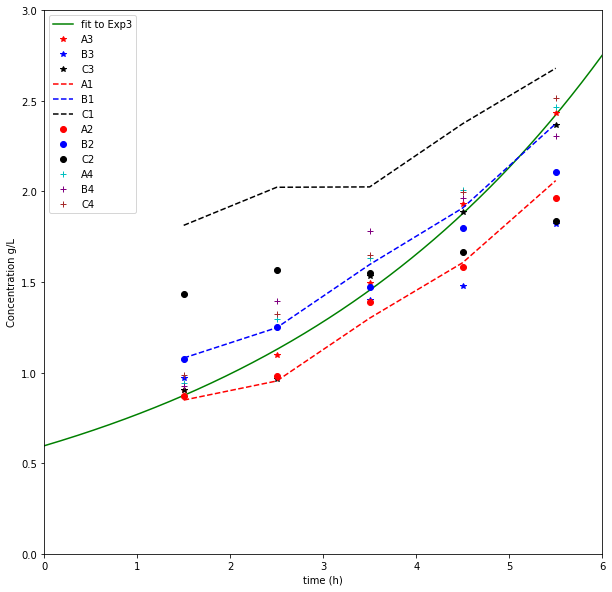

In [30]:
plt.figure(figsize=(10,10))
plt.plot(tspan, Cx, color='green',label='fit to Exp3')
plt.plot(t1, Cx_A,'*', color='red', label='A3')
plt.plot(t1, Cx_B,'*', color='blue', label='B3')
plt.plot(t1, Cx_C, '*', color='black', label='C3')
plt.plot(t1, Cx_A1,'--', color='red', label='A1')
plt.plot(t1, Cx_B1,'--', color='blue', label='B1')
plt.plot(t1, Cx_C1, '--', color='black', label='C1')
plt.plot(t1, Cx_A2,'o', color='red', label='A2')
plt.plot(t1, Cx_B2,'o', color='blue', label='B2')
plt.plot(t1, Cx_C2, 'o', color='black', label='C2')
plt.plot(t1, Cx_A4,'+', color='c', label='A4')
plt.plot(t1, Cx_B4,'+', color='purple', label='B4')
plt.plot(t1, Cx_C4, '+', color='brown', label='C4')

plt.legend(loc='best')
plt.ylabel('Concentration g/L') 
plt.xlabel('time (h)') 
plt.axis([0, 6, 0, 3])
plt.show()

# rCO 2 graph

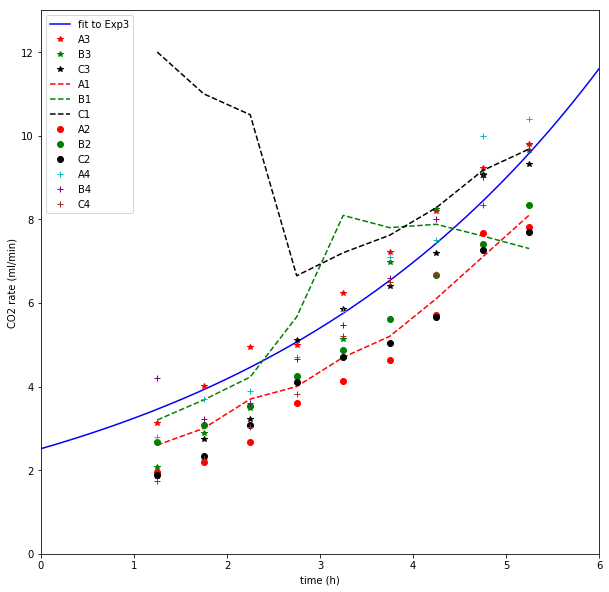

In [31]:
plt.figure(figsize=(10,10))
plt.plot(tspan, rco2, color='blue', label='fit to Exp3')
plt.plot(t2, rco2_A, '*', color='red',label='A3')
plt.plot(t2, rco2_B, '*', color='green',label='B3')
plt.plot(t2, rco2_C, '*', color='black',label='C3')
plt.plot(t2, rco2_A1, '--', color='red',label='A1')
plt.plot(t2, rco2_B1, '--', color='green',label='B1')
plt.plot(t2, rco2_C1, '--', color='black',label='C1')
plt.plot(t2, rco2_A2, 'o', color='red',label='A2')
plt.plot(t2, rco2_B2, 'o', color='green',label='B2')
plt.plot(t2, rco2_C2, 'o', color='black',label='C2')
plt.plot(t2, rco2_A4, '+', color='c',label='A4')
plt.plot(t2, rco2_B4, '+', color='purple',label='B4')
plt.plot(t2, rco2_C4, '+', color='brown',label='C4')

plt.legend(loc='best')
plt.ylabel('CO2 rate (ml/min)') 
plt.xlabel('time (h)') 
plt.axis([0, 6, 0, 13])
plt.show()

# Cs and Ce graph

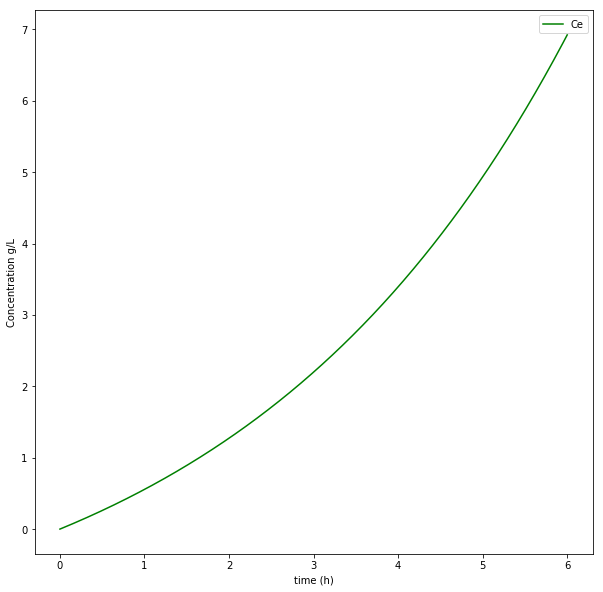

In [32]:
plt.figure(figsize=(10,10))
plt.plot(tspan, Ce, color='green',label='Ce')
# plt.plot(tspan, Cs, color='red',label='Cs')

plt.legend(loc='best')
plt.ylabel('Concentration g/L') 
plt.xlabel('time (h)') 
#plt.axis([0, 6, 0, 7])
plt.show()

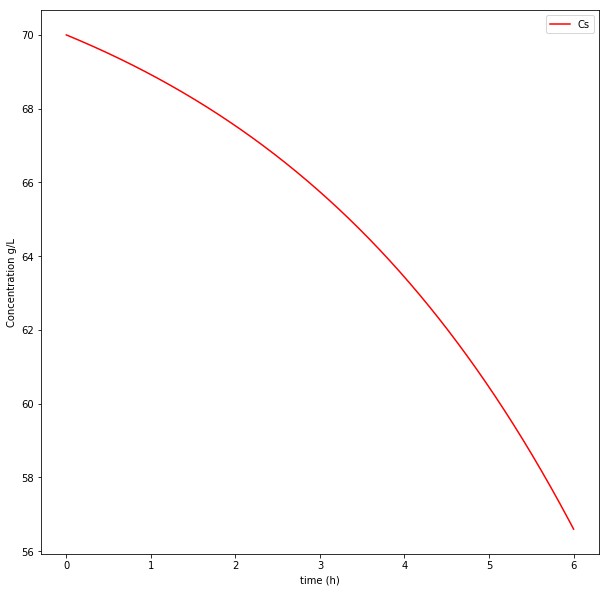

In [33]:
plt.figure(figsize=(10,10))
# plt.plot(tspan, Ce, color='green',label='Ce')
plt.plot(tspan, Cs, color='red',label='Cs')

plt.legend(loc='best')
plt.ylabel('Concentration g/L') 
plt.xlabel('time (h)') 
#plt.axis([0, 6, 0, 7])
plt.show()